In [7]:
from ts_eval.viz import metrics as mtx
from ts_eval.viz import time_slices
from ts_eval.viz.api import ts_inspect_3d
from ts_eval.viz.data_containers import xr_3d_factory


from ts_eval.models.naive import snaive_pi

In [8]:
import pandas as pd
import numpy as np
import random

from datetime import datetime, timedelta


import matplotlib.pyplot as plt


import xarray as xr


from IPython.display import display_html


In [3]:
def seasonality_ts(n, s_len=24):

    freq = n / s_len

    t = np.arange(n) / n
    c1 = 1.0 * np.sin(2 * np.pi * t * freq)
    c2 = .4 * np.sin(2 * np.pi * 15 * t)

    noise = np.random.rand(n)

    return c1 + c2 + noise


def trend(n, steepness=1.2):
    return np.arange(n) / (n**steepness) + np.random.rand(n) * 0.1

level = 50
n = 1400
period1 = 24
period2 = 24*7

ts = (level +
                trend(n, steepness=0.9) +
                seasonality_ts(n, period1) +
                seasonality_ts(n, period2))

sd = datetime(2019,2,1,0,0,0)

ts = pd.DataFrame({'ts': ts})
ts.index = pd.date_range(start=sd, end=sd + timedelta(days=ts.shape[0]-1), freq='1d')

ts_train = ts.iloc[:1000]
ts_test = ts.iloc[1000:]

/Users/vshulyak/.local/share/virtualenvs/ts-eval-VPVj6ULy/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


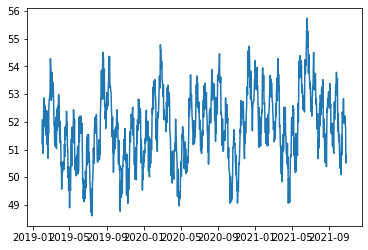

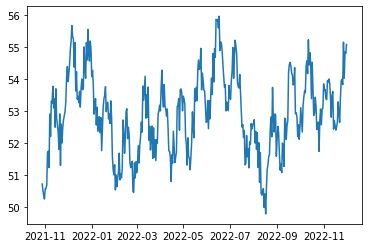

In [4]:
plt.plot(ts_train)
plt.show()
plt.plot(ts_test)

In [5]:
train_h = 24*7

# thats for simplicity in only this case
nts = ts.iloc[1000-train_h:]['ts'].values

snaive_preds = []
snaive_pi_u = []
snaive_pi_l = []

for i in range(376):
    y = nts[i:i+train_h]
#     t = nts[i+train_h:i+train_h+24]
    p, u, l = snaive_pi(y, freq=24, h=24)
    snaive_preds += [p]
    snaive_pi_u += [u]
    snaive_pi_l += [l]

snaive_preds = np.vstack(snaive_preds)
snaive_pi_u = np.vstack(snaive_pi_u)
snaive_pi_l = np.vstack(snaive_pi_l)

snaive_3d = np.stack([
    snaive_pi_u,
    snaive_preds,
    snaive_pi_l
],2)

snaive_preds.shape, snaive_pi_u.shape, snaive_pi_l.shape, snaive_3d.shape

((376, 24), (376, 24), (376, 24), (376, 24, 3))


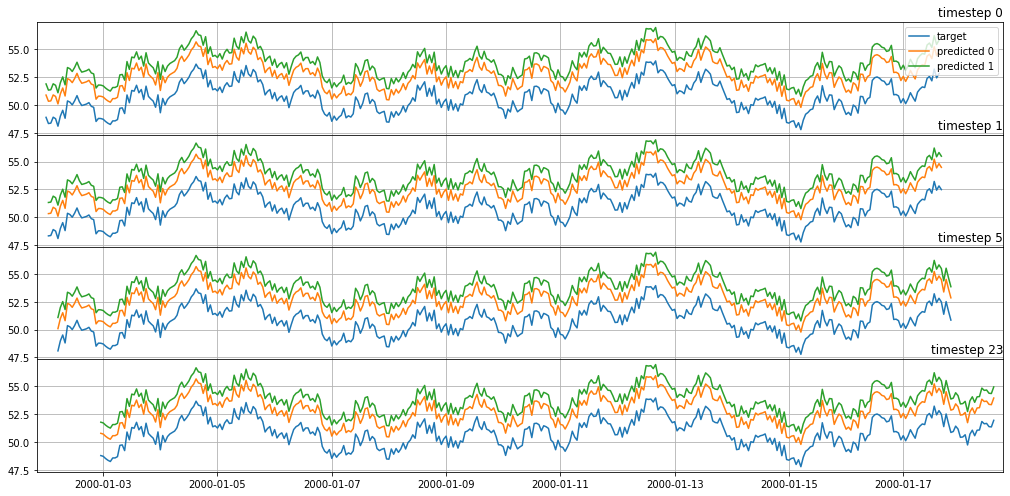

In [12]:
dataset_2d = snaive_preds - 2
dataset_3d = snaive_3d

dataset_3d_naive = dataset_3d - 1
dataset_3d_2 = dataset_3d + 1

start_date = "2000-01-02"
freq = "H"

(
    ts_inspect_3d(
        dataset_2d, dataset_3d, dataset_3d_2, start_date=start_date, freq=freq
    )
    .use_reference(
        xr_3d_factory(dataset_3d_naive, start_date=start_date, freq=freq)
    )
    .for_horizons(0, 1, 5, 23)
    .for_time_slices(time_slices.all, time_slices.weekend)
    .with_decription()
    .with_metrics(mtx.FVrMSE, mtx.FVrMAE, mtx.FVrMIS)
    .with_predictions_plot()
    .show()
)